# Sector ETFs Recommender System
###Objective: To train a stacking machine learning model that can predict whether the Sector ETF will be in the 50th percentile in next-day's return. 
### Members: Johann Ko, Yuen Jing Wen, Kan Zi Jun

In [0]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
import datetime
import cvxpy as cp

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Inputs

### We select the oldest set of Sector ETFs:
* SPDR Consumer Staples ETF (XLP) 1998-12-16
* SPDR Consumer Discretionary ETF (XLY) 1998-12-16
* SPDR Energy ETF (XLE) 1998-12-16
* SPDR Financials ETF (XLF) 1998-12-16
* SPDR Health Care ETF (XLV) 1998-12-16
* SPDR Industrial ETF (XLI) 1998-12-16
* SPDR Materials ETF (XLB) 1998-12-16
* SPDR Technology ETF (XLK) 1998-12-16
* SPDR Utilities ETF (XLU) 1998-12-16


---


### Excluded:
* SPDR Telecommunication Services ETF (XLC) 2018-06-18
* SPDR Real Estate ETF (XLRE) 2015-10-07

Note: Due to the relative infancy of Sector ETF concept, our dataset is limited and recent.

In [0]:
#Input Sector ETF Tickers
tickers = ['XLP', 'XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
PERCENTILE = 50

#User input
TICKER_OF_INTEREST = 'XLI'

In [0]:
#Input dates
startdate = datetime.datetime(1999, 3, 31)
enddate =  datetime.datetime(2019, 4, 1)

#Extra data for Arima model
arima_startdate = datetime.datetime(1998, 12, 17)
arima_enddate = datetime.datetime(1999, 3, 30)

#Extra data
extra_startdate = datetime.datetime(1998, 12, 18)
extra_enddate =  datetime.datetime(1999, 3, 30)

# Data Retrieval

In [0]:
#Retrieve prices
prices_dict = {}
volumes_dict = {}
for ticker in tickers:
    ticker_prices = pdr.get_data_yahoo(ticker, startdate, enddate)
    prices_dict[ticker] = ticker_prices['Adj Close']
    volumes_dict[ticker] = ticker_prices['Volume']
    

#Returns
prices = pd.DataFrame(prices_dict)
returns = prices.pct_change().dropna()

#Volume
volumes = pd.DataFrame(volumes_dict)

In [0]:
print(prices.head())

                  XLP        XLY        XLE        XLF        XLV        XLI  \
Date                                                                           
1999-03-31  16.842590  22.464611  16.717981  10.358640  21.179268  17.391840   
1999-04-01  16.872454  22.440058  16.696735  10.384600  21.179268  17.577068   
1999-04-05  16.962038  22.734673  17.100344  10.592298  21.652006  17.958490   
1999-04-06  16.772900  22.857431  16.930399  10.514409  21.675617  17.860359   
1999-04-07  16.753000  23.053844  16.760468  10.799989  22.089293  17.893078   

                  XLB        XLK        XLU  
Date                                         
1999-03-31  13.812929  28.989637  13.063733  
1999-04-01  13.971704  29.447622  13.339084  
1999-04-05  14.140392  30.462664  13.446134  
1999-04-06  13.892311  30.722591  13.377311  
1999-04-07  14.041169  30.648363  13.553245  


In [0]:
#5032 rows
print(returns.head())


                 XLP       XLY       XLE       XLF       XLV       XLI  \
Date                                                                     
1999-04-01  0.001773 -0.001093 -0.001271  0.002506  0.000000  0.010650   
1999-04-05  0.005310  0.013129  0.024173  0.020001  0.022321  0.021700   
1999-04-06 -0.011151  0.005400 -0.009938 -0.007353  0.001090 -0.005464   
1999-04-07 -0.001186  0.008593 -0.010037  0.027161  0.019085  0.001832   
1999-04-08  0.023173  0.022364  0.010139  0.018027  0.010167  0.005480   

                 XLB       XLK       XLU  
Date                                      
1999-04-01  0.011495  0.015798  0.021077  
1999-04-05  0.012074  0.034469  0.008025  
1999-04-06 -0.017544  0.008533 -0.005118  
1999-04-07  0.010715 -0.002416  0.013152  
1999-04-08  0.014134  0.009693  0.026521  


In [0]:
returns

,XLP,XLY,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
1999-04-01,0.001773,-0.001093,-0.001271,0.002506,0.000000,0.010650,0.011495,0.015798,0.021077
1999-04-05,0.005310,0.013129,0.024173,0.020001,0.022321,0.021700,0.012074,0.034469,0.008025
1999-04-06,-0.011151,0.005400,-0.009938,-0.007353,0.001090,-0.005464,-0.017544,0.008533,-0.005118
1999-04-07,-0.001186,0.008593,-0.010037,0.027161,0.019085,0.001832,0.010715,-0.002416,0.013152
1999-04-08,0.023173,0.022364,0.010139,0.018027,0.010167,0.005480,0.014134,0.009693,0.026521
1999-04-09,0.002323,0.009375,0.018820,-0.002361,0.003176,0.000608,-0.004878,-0.001600,-0.007146
1999-04-12,0.016802,0.008256,0.007390,0.017754,0.025344,0.024213,0.029411,-0.015226,0.014398
1999-04-13,0.003419,-0.005117,-0.001223,-0.001165,-0.010299,0.007682,0.012245,-0.015458,-0.016377
1999-04-14,-0.030097,-0.022633,-0.012240,-0.012803,-0.009363,0.021700,0.048387,-0.024793,-0.014427


In [0]:
#Retrieve Volume
print(volumes.head())

                 XLP      XLY       XLE       XLF      XLV      XLI      XLB  \
Date                                                                           
1999-03-31   45800.0  24400.0   67000.0  112600.0   6300.0  21700.0  10600.0   
1999-04-01   38500.0   4100.0   22000.0   52900.0  22500.0   3500.0  12300.0   
1999-04-05   32900.0   9600.0   58400.0   92900.0  12400.0   7700.0  11900.0   
1999-04-06  136600.0  10900.0   42600.0  142400.0  14500.0   2700.0  52800.0   
1999-04-07   77800.0  13600.0  836400.0  324700.0  15700.0  24400.0  45200.0   

                  XLK      XLU  
Date                            
1999-03-31   774700.0  20500.0  
1999-04-01   318500.0  11200.0  
1999-04-05  1003500.0   8400.0  
1999-04-06   540100.0  38900.0  
1999-04-07   931700.0  29100.0  


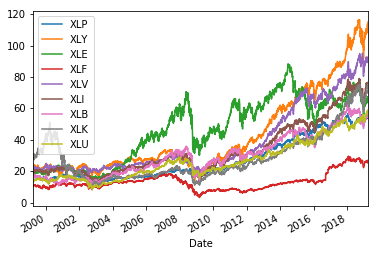

In [0]:
prices.plot()

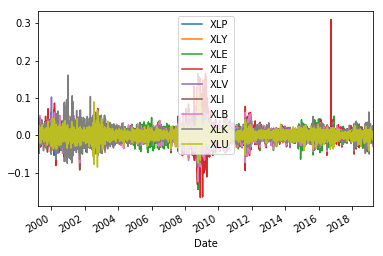

In [0]:
returns.plot()

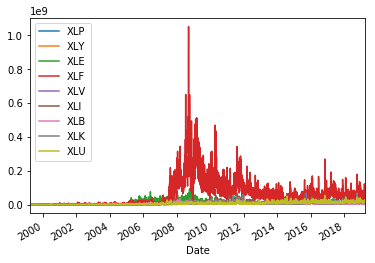

In [0]:
volumes.plot()

In [0]:
#Create DF

from sklearn.preprocessing import LabelEncoder

df = returns.copy()
df.columns = [str(col) + '_returns' for col in df.columns]

#what if there are >1 max?
max_next_day = df.idxmax(axis = 1)

df["max_next_day"] = max_next_day
df.max_next_day = df.max_next_day.shift(-1)

df.drop(df.tail(1).index,inplace=True) #remove last row

le = LabelEncoder()
df['labelencode_max_next_day'] = le.fit_transform(df['max_next_day'])

In [0]:
#Add Volume into DF
#Removed first and last because Zijun removed that in her code
for ticker in tickers:
  df[ticker+'_vol'] = volumes[ticker][1:-1]

In [0]:
#Add forward-looking next day's returns (This column will not be used for training. Only for post-analysis)

look_forward_returns = returns.copy().iloc[1:,:]
df_forward_returns = pd.DataFrame(index= df.index.tolist())

for ticker in tickers:
  look_forward_returns_list = look_forward_returns[ticker].tolist()
  df_forward_returns[ticker+'_1D_forward_returns'] = look_forward_returns_list

In [0]:
#Create Desired output column
returns_temp = returns.copy()
returns_temp.columns = [str(col) + '_returns' for col in returns_temp.columns]
returns_temp[str(PERCENTILE) + ' Percentile'] = returns_temp.quantile(q=PERCENTILE/100,axis=1)
returns_temp['>' + str(PERCENTILE) + ' Percentile?'] = np.where(returns_temp[TICKER_OF_INTEREST + '_returns'] >= returns_temp[str(PERCENTILE) + ' Percentile'], 1, 0)

returns_temp.drop(returns_temp.tail(1).index,inplace=True)
df = pd.concat([df, returns_temp], axis=1, join='inner')

df = df.loc[:,~df.columns.duplicated()]



#Initial Analysis

In [0]:
#Composition of Desired output in dataset
df['>' + str(PERCENTILE) + ' Percentile?'].value_counts()

1    2897
0    2134
Name: >50 Percentile?, dtype: int64

In [0]:
#Check average daily returns
print(returns.mean(axis=0))

XLP    0.000283
XLY    0.000421
XLE    0.000421
XLF    0.000369
XLV    0.000355
XLI    0.000382
XLB    0.000394
XLK    0.000318
XLU    0.000363
dtype: float64


In [0]:
#Sector with Highest Returns
print("\n"+"Sector with Highest Returns: " + np.argmax(returns.mean(axis=0)))



Sector with Highest Returns: XLY


In [0]:
#Composition of Dataset
for ticker in returns.columns:
  print("% of Dataset max_next_day_return that is " + ticker + ": " + str(len(df[df["max_next_day"] == ticker+"_returns"])/len(df)))

% of Dataset max_next_day_return that is XLP: 0.08884913536076326
% of Dataset max_next_day_return that is XLY: 0.0725501888292586
% of Dataset max_next_day_return that is XLE: 0.20333929636255219
% of Dataset max_next_day_return that is XLF: 0.11329755515802027
% of Dataset max_next_day_return that is XLV: 0.08547008547008547
% of Dataset max_next_day_return that is XLI: 0.05108328364142318
% of Dataset max_next_day_return that is XLB: 0.10812959650168953
% of Dataset max_next_day_return that is XLK: 0.11965811965811966
% of Dataset max_next_day_return that is XLU: 0.15762273901808785


# Feature Engineering

## Day of Week

In [0]:
# dates = df.index.tolist()
# day_of_week=[]
# for i in range(0, len(dates)):
#   day = dates[i].to_pydatetime().weekday()
#   day_of_week.append(day)
# df['day_of_week'] = day_of_week

# df.head()

##Facebook Prophet

In [0]:
from fbprophet import Prophet
import plotly.offline as py
import plotly.graph_objs as go

for ticker in tickers:
#   prices[ticker].plot()
  prices_fbp = pd.DataFrame(prices[ticker][1:]).reset_index()
  prices_fbp.columns = ['ds', 'y' ]
  
  p = Prophet(changepoint_prior_scale=3.0, daily_seasonality=True)
  p.add_seasonality(name='monthly', period=60, fourier_order=5)
  p.fit(prices_fbp)
  future_prices = p.make_future_dataframe(periods=365)
  forecast_prices = p.predict(future_prices)
  

  forecast_prices = forecast_prices[:len(df)]
  
  df[str(ticker)+'_trend'] = forecast_prices['trend'].tolist()
  df[str(ticker)+'_yhat_lower'] = forecast_prices['yhat_lower'].tolist()
  df[str(ticker)+'_yhat_upper'] = forecast_prices['yhat_upper'].tolist()
  df[str(ticker)+'_trend_lower'] = forecast_prices['trend_lower'].tolist()
  df[str(ticker)+'_trend_upper'] = forecast_prices['trend_upper'].tolist()
  df[str(ticker)+'_additive_terms'] = forecast_prices['additive_terms'].tolist()
  df[str(ticker)+'_additive_terms_lower'] = forecast_prices['additive_terms_lower'].tolist()
  df[str(ticker)+'_additive_terms_upper'] = forecast_prices['additive_terms_upper'].tolist()
  df[str(ticker)+'_weekly'] = forecast_prices['weekly'].tolist()
  df[str(ticker)+'_weekly_lower'] = forecast_prices['weekly_lower'].tolist()
  df[str(ticker)+'_weekly_upper'] = forecast_prices['weekly_upper'].tolist()
  df[str(ticker)+'_yearly'] = forecast_prices['yearly'].tolist()
  df[str(ticker)+'_yearly_lower'] = forecast_prices['yearly_lower'].tolist()
  df[str(ticker)+'_yearly_upper'] = forecast_prices['yearly_upper'].tolist()
  df[str(ticker)+'_yhat'] = forecast_prices['yhat'].tolist()
  

print(df.head())

            XLP_returns  XLY_returns  XLE_returns  XLF_returns  XLV_returns  \
Date                                                                          
1999-04-01     0.001773    -0.001093    -0.001271     0.002506     0.000000   
1999-04-05     0.005310     0.013129     0.024173     0.020001     0.022321   
1999-04-06    -0.011151     0.005400    -0.009938    -0.007353     0.001090   
1999-04-07    -0.001186     0.008593    -0.010037     0.027161     0.019085   
1999-04-08     0.023173     0.022364     0.010139     0.018027     0.010167   

            XLI_returns  XLB_returns  XLK_returns  XLU_returns max_next_day  \
Date                                                                          
1999-04-01     0.010650     0.011495     0.015798     0.021077  XLK_returns   
1999-04-05     0.021700     0.012074     0.034469     0.008025  XLK_returns   
1999-04-06    -0.005464    -0.017544     0.008533    -0.005118  XLF_returns   
1999-04-07     0.001832     0.010715    -0.002416  

## ARIMA Time Series Model

In [0]:
#ARIMA
import statsmodels.tsa.api as smt

#Retrieve prices
arima_prices_dict = {}
for ticker in tickers:
    arima_ticker_prices = pdr.get_data_yahoo(ticker, arima_startdate, enddate)
    arima_prices_dict[ticker] = arima_ticker_prices['Adj Close']
    
arima_prices = pd.DataFrame(arima_prices_dict)

for ticker in tickers:
  ticker_arima_predictions = []
  for i in range(len(arima_prices[ticker].loc[:startdate]),len(arima_prices)):
    #Just to use previous 50 prices for training
    tmp_prices = arima_prices[ticker].iloc[:i]
    training_prices_for_this_date = tmp_prices[-50:]

    arima = smt.ARIMA(training_prices_for_this_date, (1,0,0)) 
    arima_fit = arima.fit()
    num_steps = 1
    forecast_mean, forecast_std, forecast_ci = arima_fit.forecast(steps=num_steps)
    ticker_arima_predictions.append(forecast_mean)

  #Delete last one because Zijun took away last row. Just delete next line if Zijun's code has been updated.
  ticker_arima_predictions = ticker_arima_predictions[:-1]

  #Add to df
  df[ticker + '_arima'] = ticker_arima_predictions

  
  
#Change ARIMA predictions to returns
for ticker in tickers:
  df[ticker+'_arima'] = (df[ticker+'_arima'] - prices[ticker][1:-1]) / prices[ticker][1:-1]

In [0]:
# #Remove this cell and uncomment above if you want to repredict with ARIMA. Otherwise, retrieve the pre-predicted csv to save time
# from google.colab import drive
# drive.mount('/content/gdrive')

# ticker_arima_predictions = pd.read_csv('gdrive/My Drive/arima_file.csv')

# for ticker in tickers:
#   df[ticker + '_arima'] = ticker_arima_predictions[ticker + '_arima'].tolist()
  
# #Change ARIMA predictions to returns

# for ticker in tickers:
#   df[ticker+'_arima'] = (df[ticker+'_arima'] - prices[ticker][1:-1]) / prices[ticker][1:-1]

## Simple Moving Averages

In [0]:
#Add Additional training data
extra_prices_dict = {}
for ticker in tickers:
    extra_ticker_prices = pdr.get_data_yahoo(ticker, extra_startdate, enddate)
    extra_prices_dict[ticker] = extra_ticker_prices['Adj Close']
    
extra_prices = pd.DataFrame(extra_prices_dict)

for ticker in tickers:
  extra_prices[ticker + '_rolling_mean20'] = extra_prices[ticker].rolling(window=20).mean()
  extra_prices[ticker + '_rolling_mean50'] = extra_prices[ticker].rolling(window=50).mean()
  df[ticker + '_rolling_mean'] = extra_prices[ticker + '_rolling_mean20'][df.index.values]
  df[ticker + '_rolling_mean50'] = extra_prices[ticker + '_rolling_mean50'][df.index.values]
  df[ticker + '_rolling_mean_difference'] = df[ticker + '_rolling_mean'] - df[ticker + '_rolling_mean50']
  plt.plot(prices[ticker], label=ticker)
  plt.plot(prices[ticker + '_rolling_mean'], label= ticker + '20 Day SMA', color='orange')
  plt.plot(prices[ticker + '_rolling_mean2'], label= ticker + ' 50 Day SMA', color='magenta')
  plt.legend(loc='upper left')
  plt.show()

## Exponential Moving Averages

In [0]:
for ticker in tickers:
  extra_prices[ticker + '_exp20'] = extra_prices[ticker].ewm(span=20, adjust=False).mean()
  extra_prices[ticker + '_exp50'] = extra_prices[ticker].ewm(span=50, adjust=False).mean()
  df[ticker + '_exp20'] = extra_prices[ticker + '_exp20'][df.index.values]
  df[ticker + '_exp50'] = extra_prices[ticker + '_exp50'][df.index.values]
  df[ticker + '_exp_difference'] = df[ticker + '_exp20'] - df[ticker + '_exp50']
  
  plt.plot(prices[ticker], label=ticker)
  plt.plot(prices[ticker + '_exp1'], label=ticker + '20 Day EMA')
  plt.plot(prices[ticker + '_exp2'], label=ticker + '50 Day EMA')
  plt.legend(loc='upper left')
  plt.show()

## Data Pre-processing

In [0]:
#create x and y
x = df.drop(['max_next_day', 'labelencode_max_next_day','>' + str(PERCENTILE) + ' Percentile?'], axis=1).copy() #making copies so editing x & y wouldnt change df
y = df['>' + str(PERCENTILE) + ' Percentile?'].copy()

#Change to between 0 to 1
scaler = MinMaxScaler()
  
x_values = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_values)
x = pd.DataFrame(x_scaled, columns=x.columns)


In [0]:
x.head()

## Final Check for Null Values

In [0]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

## Split Testing and Training Set 

In [0]:
#Split Test and Train set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=False)
x_stack_train, x_stack_test, y_stack_train, y_stack_test = train_test_split(x_test, y_test, test_size=0.4, shuffle=False)

# Training models

In [0]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor

In [0]:
#SVM
clf1 = svm.SVC(gamma='scale')
clf1.fit(x_train, y_train)
clf1_predictions = clf1.predict(x_stack_train)
print(clf1.score(x_test, y_test))

In [0]:
#Random Forest
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2.fit(x_train, y_train)
clf2_predictions = clf2.predict(x_stack_train)
print(clf2.score(x_test, y_test))

In [0]:
#XGBoost
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf3 = XGBClassifier()
clf3.fit(x_train, y_train)
clf3_predictions = clf3.predict(x_stack_train)
clf3_predictions = np.rint(clf3_predictions)
clf3_predictions = clf3_predictions.astype(int)
# print(accuracy_score(y_stack_train, clf3_predictions))
print(clf3.score(x_test, y_test))

In [0]:
clf1_predictions_reshaped = clf1_predictions.reshape(-1,1)
df_predictions = pd.DataFrame(clf1_predictions_reshaped, columns=['clf1'])

clf2_predictions_reshaped = clf2_predictions.reshape(-1,1)
df_predictions['clf2'] = clf2_predictions_reshaped

clf3_predictions_reshaped = clf3_predictions.reshape(-1,1)
df_predictions['clf3'] = clf3_predictions_reshaped

df_predictions.head()

#Stacking Training

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
#Neural Networking Stacking Model
clf4 = MLPClassifier(hidden_layer_sizes=100, solver='sgd', learning_rate='adaptive') #adaptive only for sgd
clf4.fit(df_predictions, y_stack_train)


#Test stacking model
clf1_predictions = clf1.predict(x_stack_test)
clf2_predictions = clf2.predict(x_stack_test)
clf3_predictions = clf3.predict(x_stack_test)
clf3_predictions = np.rint(clf3_predictions)
clf3_predictions = clf3_predictions.astype(int)


clf1_predictions_reshaped = clf1_predictions.reshape(-1,1)
df_test_predictions = pd.DataFrame(clf1_predictions_reshaped, columns=['clf1'])

clf2_predictions_reshaped = clf2_predictions.reshape(-1,1)
df_test_predictions['clf2'] = clf2_predictions_reshaped

clf3_predictions_reshaped = clf3_predictions.reshape(-1,1)
df_test_predictions['clf3'] = clf3_predictions_reshaped
print(clf4.score(df_test_predictions, y_stack_test))

#Testing of Models

In [0]:
#Test Score
print('Test score for clf1: ' + str(clf1.score(x_test, y_test)))
print('Test score for clf2: ' + str(clf2.score(x_test, y_test)))
print('Test score for clf3: ' + str(clf3.score(x_test, y_test)))
print('Test score for clf4: ' + str(clf4.score(df_test_predictions, y_stack_test)))


# Post-Analysis

In [0]:
#Find best feature for Random Forest 
importances = clf2.feature_importances_
indices = range(0, len(importances))

for i in range(0,len(importances)):
  print(str(x.columns[i]) +' importances: ' + str(importances[i]))

In [0]:
# Plot the feature importances of the forest
features = x.columns
plt.figure()
plt.title("Feature importances")
plt.bar (indices, importances)
plt.show()

In [0]:
#Max importance
max_importance = 0

for i in range(0,len(importances)):
  if importances[i] >= importances[max_importance]:
    max_importance = i
print('Most important feature is: ' + str(x.columns[max_importance]))

In [0]:
#Predicted Returns
clf4_predictions = clf4.predict(df_test_predictions)

predicted_returns = []

clf4_predictions = [x==1 for x in clf4_predictions]

dates_bought = x_stack_test[clf4_predictions]

for i in dates_bought.index.tolist():
  predicted_returns.append(df_forward_returns.iloc[i,:][TICKER_OF_INTEREST+'_1D_forward_returns'])
  
mean_predicted_returns = sum(predicted_returns) / len(predicted_returns)
print('Mean Predicted Returns: ' + str(mean_predicted_returns))


# #Per ticker returns
# print(x_stack_test[x_stack_test.columns[0:9]].mean(axis=0))


In [0]:
print('Mean Predicted Returns: ' + str(mean_predicted_returns))
for ticker in tickers:
  ticker_returns = []
  for i in range(x_stack_test.index[0], x_stack_test.index[-1]+1):
    ticker_returns.append(df[ticker + '_returns'].iloc[i])
  
  mean_ticker_returns = sum(ticker_returns) / len(ticker_returns)
  print(ticker + ' Returns: ' + str(mean_ticker_returns))
  

# Export Model

In [0]:
#Save Model

#Export Model
#Run for google, otherwise comment this and run below

# from google.colab import drive
# drive.mount('/content/gdrive')
# result.to_csv("/content/gdrive/My Drive/Colab Notebooks/submission_file.csv", index=False)

# #Run for local machine
# result.to_csv("./submission_file.csv", index=False)